![Alt Text](resources/screenshots/loading_screen.png)

# Project 4 - Advanced Lane Finding Project

### _An Expansion of "Project 1 - Finding Lane Lines"_

#### Please refer to this repository's README.md for a detailed explanation of the project: 
https://github.com/nhiddink/CarND_P4_Advanced_Lane_Finding/blob/master/README.md

### Imports

In [1]:
# http://www.numpy.org/
import numpy as np

# http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html
import cv2

# http://matplotlib.org/
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt <---Does not work in Python 3 on Mac

# https://docs.python.org/2/library/pickle.html
import pickle

# https://docs.python.org/2/library/glob.html
import glob

# https://docs.python.org/2/library/os.html
import os

### I. Camera Calibration
#### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('resources/camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

### II. Distortion Correction

#### Apply a distortion correction to raw images:

In [3]:
# Test undistortion on an image
img = cv2.imread('resources/camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('resources/camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("resources/camera_cal/dist_pickle.p", "wb"));

#### Visualize Undistortion using test_dist and test_undist:

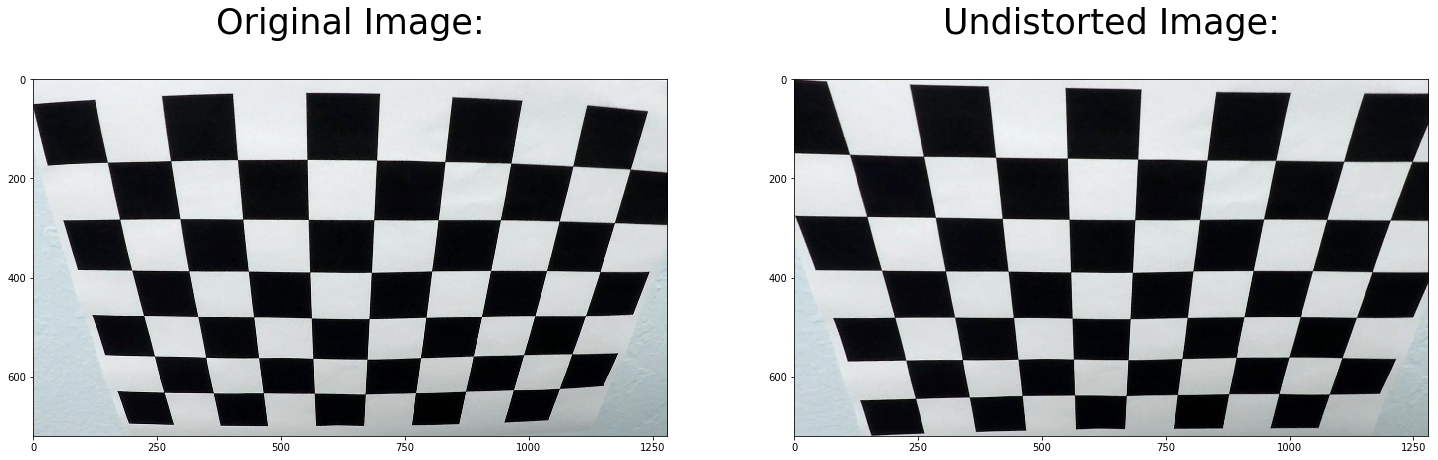

In [4]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10));

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(img);
ax1.set_title('Original Image:\n', fontsize=35)
ax2.imshow(dst);
ax2.set_title('Undistorted Image:\n', fontsize=35)

#### Function to unwarp an image:

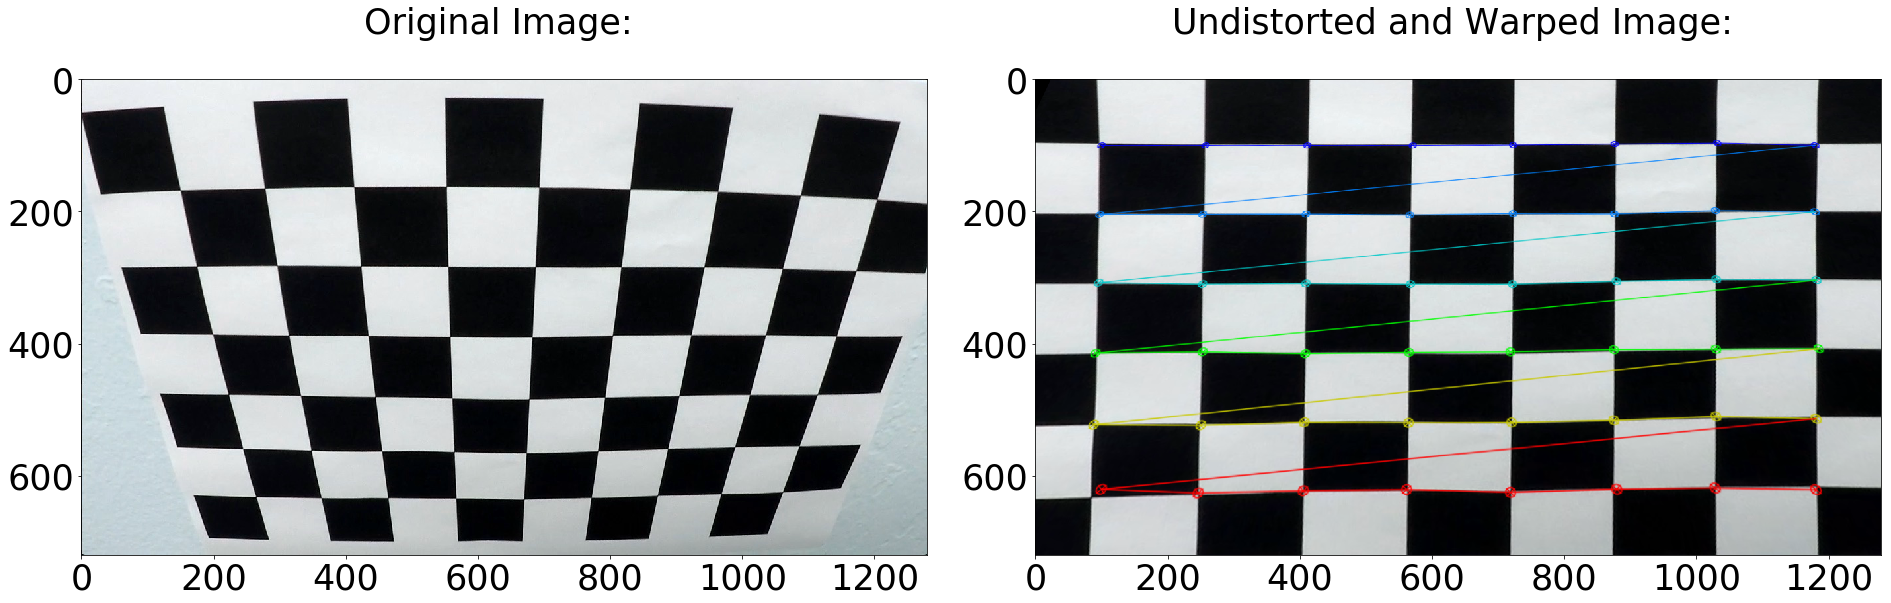

In [5]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "resources/camera_cal/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('resources/camera_cal/calibration2.jpg')
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(img)
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

### III. Color & Gradient Thresholds
#### Use color transforms and gradient operators to create a thresholded binary image.



#### <center> Original Image: </center>
![ScreenShots](resources/test_images/test2.jpg)

In [6]:
img = cv2.imread('resources/test_images/test2.jpg')

#### Visualizing Sobel Operators (x and y directions):

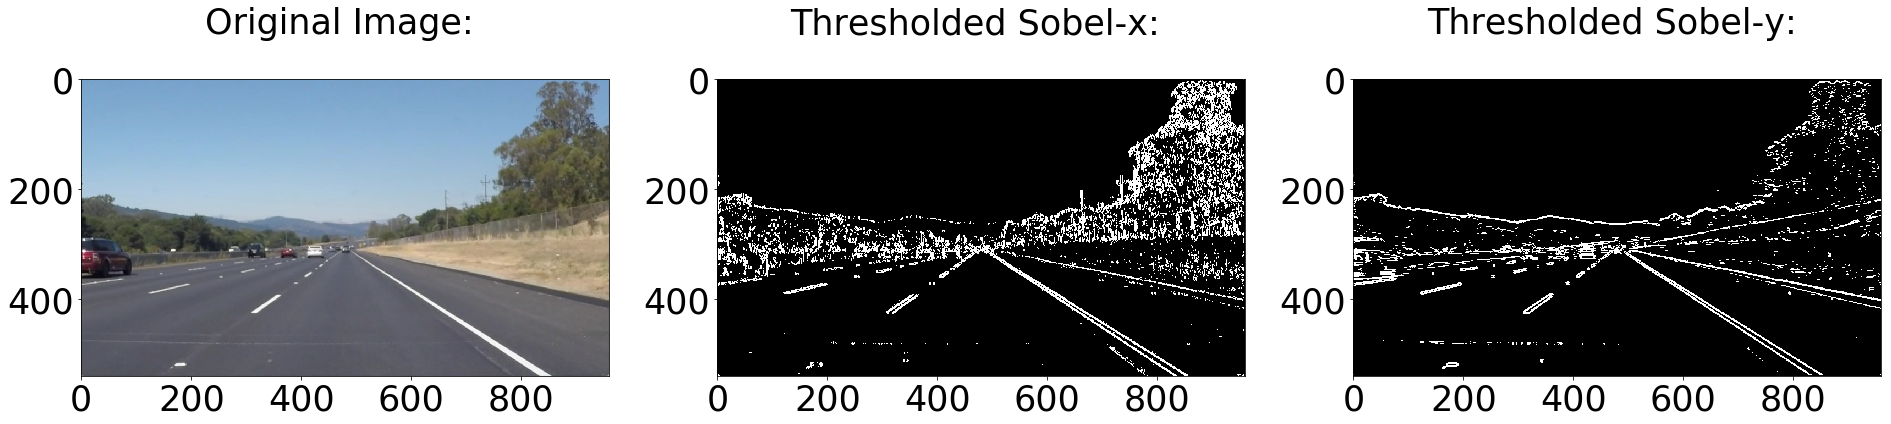

In [7]:
def sobel_operator(img, orient='x', threshold_MIN=0, threshold_MAX=255):
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply cv2.Sobel() in x and y
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        #print('Sobel taken in {} direction.'.format(orient))
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        #print('Sobel taken in {} direction.'.format(orient))
    else:
        print('Error: Incorrect orientation of sobel operator.')
    
    # Take the absolute values of the output from cv2.Sobel()
    abs_sobel = np.absolute(sobel)
    
    # Scale the results to 8-bit ranges (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create Binary Outputs
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= threshold_MIN) & (scaled_sobel <= threshold_MAX)] = 1
    
    return binary_output

# Call function and plot visualization
binary_x = sobel_operator(img, orient='x', threshold_MIN=10, threshold_MAX=255)
binary_y = sobel_operator(img, orient='y', threshold_MIN=25, threshold_MAX=255)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(binary_x, cmap='gray')
ax2.set_title('Thresholded Sobel-x: \n', fontsize=35)
ax3.imshow(binary_y, cmap='gray')
ax3.set_title('Thresholded Sobel-y: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

#### Visualizing Gradient Magnitude:

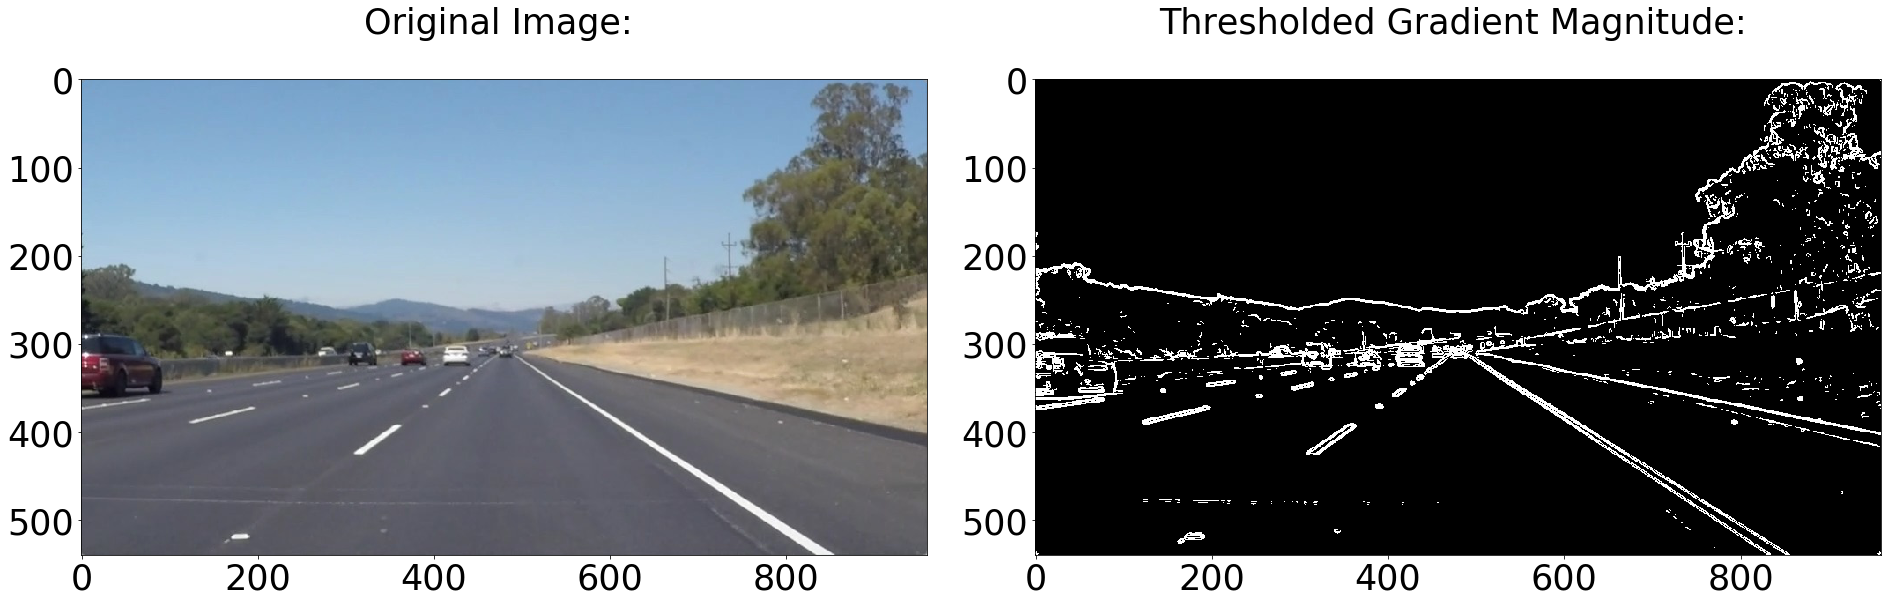

In [8]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def gradient_magnitude(img, sobel_kernel=9, mag_threshold=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_threshold[0]) & (gradmag <= mag_threshold[1])] = 1

    # Return the binary image
    return binary_output

# Call function and plot visualization
mag = gradient_magnitude(img, sobel_kernel=3, mag_threshold=(30, 200))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(mag, cmap='gray')
ax2.set_title('Thresholded Gradient Magnitude: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

#### Visualizing Gradient Direction:

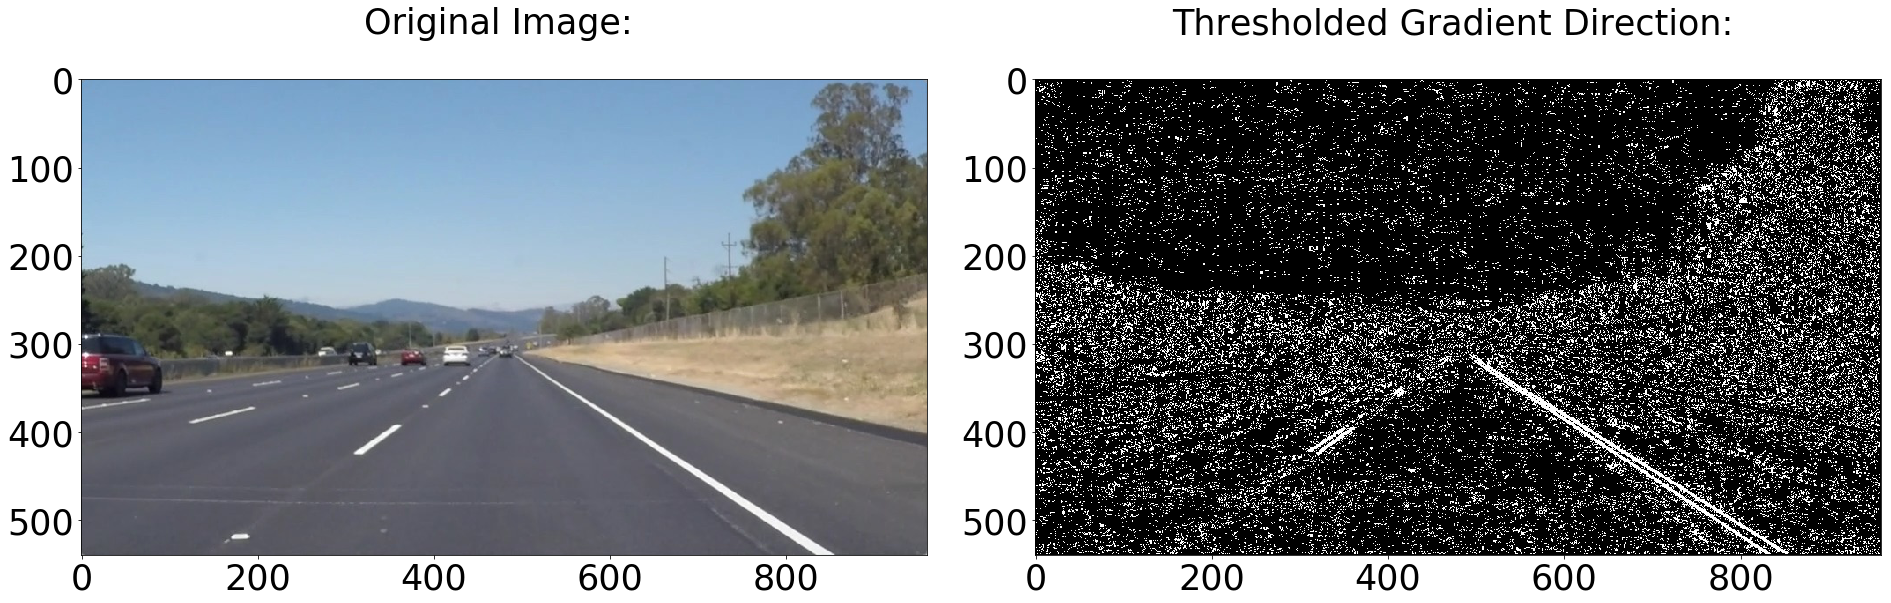

In [9]:
# Define a function that applies Sobel x and y, then computes the direction of the gradient.
def gradient_direction(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients using Sobel()
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value and calculate the direction of the gradient
    abs_grad_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))

    # Create a binary mask where the direction thresholds meet 
    binary_output =  np.zeros_like(abs_grad_dir)
    binary_output[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Call function and plot visualization
direct = gradient_direction(img, sobel_kernel=3, thresh=(0.8, 1.2))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(direct, cmap='gray')
ax2.set_title('Thresholded Gradient Direction: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

#### Visualizing HLS Color Thresholding (S-Channel):

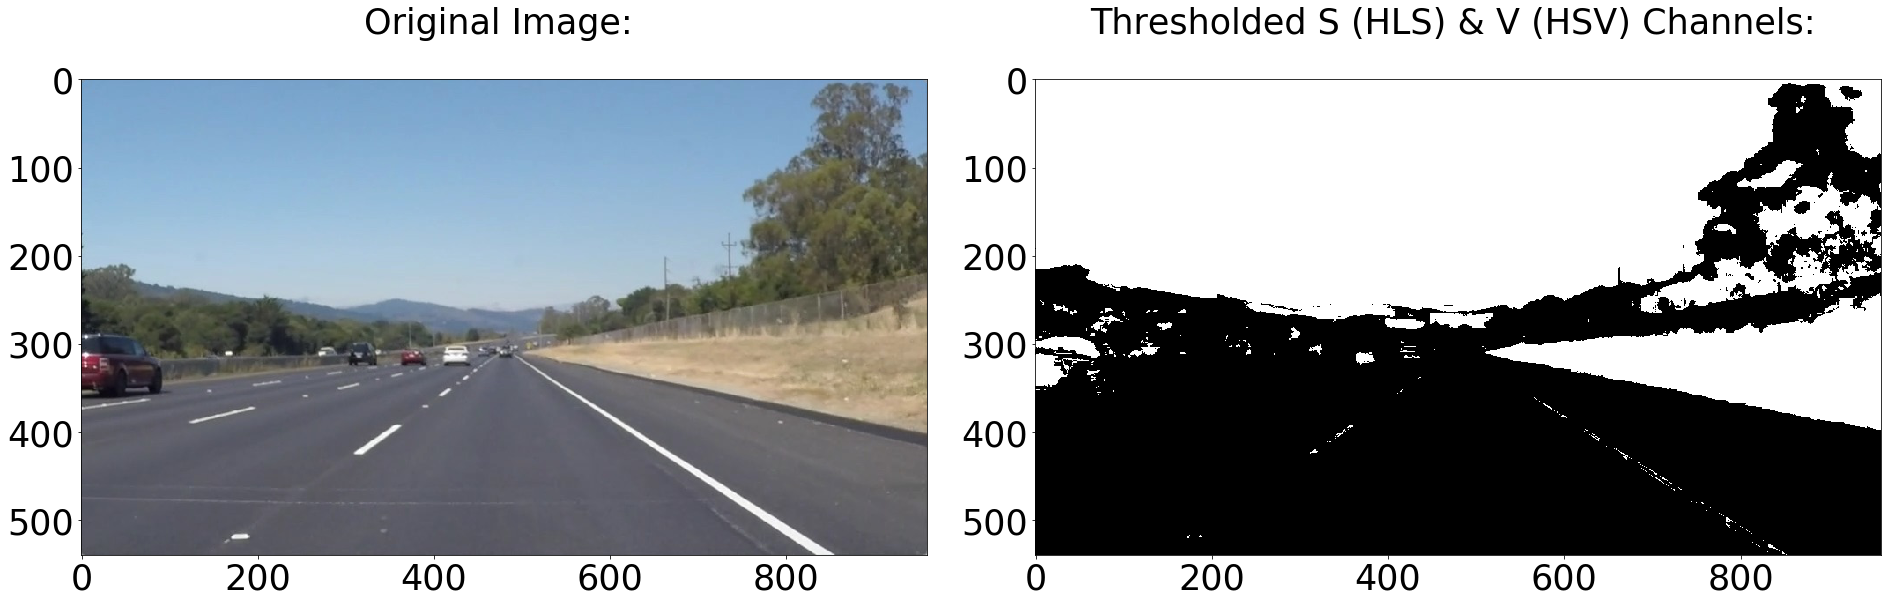

In [10]:
# Define a function that thresholds the S-channel of HLS
def color_threshold(img, HLS_s_threshold=(0, 255), HSV_v_threshold=(0,255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) # Convert to HLS format
    s_channel = hls[:,:,2] # Apply threshold s-channel
    s_binary = np.zeros_like(s_channel) # Placeholder zeros in matrix
    s_binary[(s_channel > HLS_s_threshold[0]) & (s_channel <= HLS_s_threshold[1])] = 1 # Create s-channel binary mask
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) # Convert to HSV format
    v_channel = hsv[:,:,2] # Apply threshold v-channel
    v_binary = np.zeros_like(v_channel) # Placeholder zeros in matrix
    v_binary[(v_channel > HSV_v_threshold[0]) & (v_channel <= HSV_v_threshold[1])] = 1  # Create v-channel binary mask
    
    binary_output = np.zeros_like(s_channel) # Placeholder zeros in matrix
    binary_output[(s_binary == 1) & (v_binary == 1)] = 1 # Create output binary mask
    
    # Return the result
    return binary_output

# Call function and plot visualization
color = color_threshold(img, HLS_s_threshold=(40, 255), HSV_v_threshold=(40,255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(color, cmap='gray')
ax2.set_title('Thresholded S (HLS) & V (HSV) Channels: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

#### Binary Results from Multiple Thresholds:

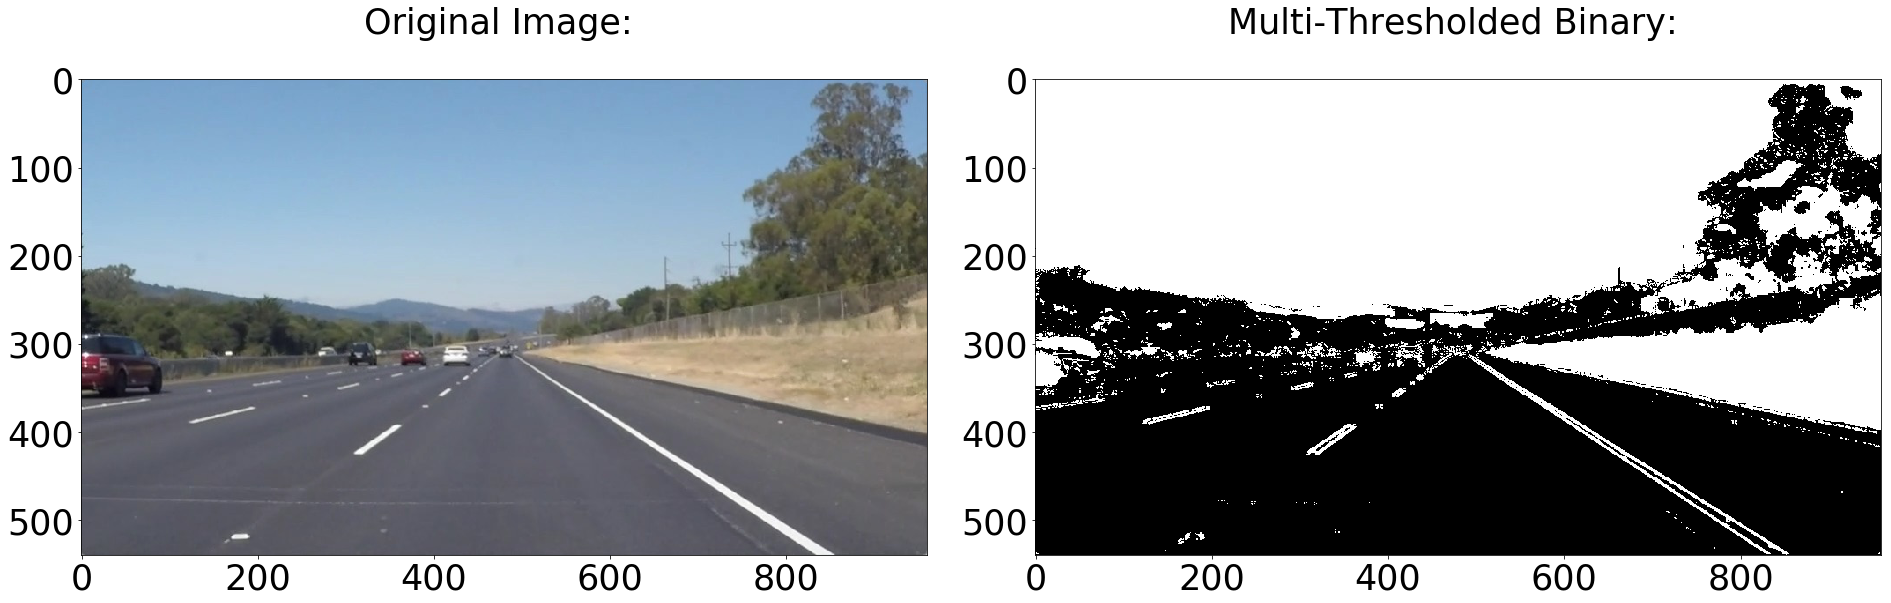

In [11]:
# Combine thresholds and plot visualization
def combined_thresholds(img, binary_x, binary_y, mag, direct, color):
    
    # Combine Sobel Operators, Gradient Magnitude & Gradient Direction Results
    #sobel_grad_combined = np.zeros_like(img)
    #sobel_grad_combined[((binary_x == 1) & (binary_y == 1))] = 1
    #sobel_grad_combined[(mag == 1)] = 1
    #sobel_grad_combined[((binary_x == 1) & (binary_y == 1)) | ((mag == 1) & (direct == 1))] = 1

    # Combine Previous Result with Color Thresholded Result
    #output = np.zeros_like(sobel_grad_combined)
    output = np.zeros_like(img)
    #output[(color == 1) & (sobel_grad_combined == 1)] = 1
    #output[(color == 1) & (mag == 1)] = 1
    output[(binary_x == 1) & (binary_y == 1) | (color == 1)] = 255
    #output[(sobel_grad_combined == 1)] = 1
    #output[(color == 1)] = 1
    return output
    
combined = combined_thresholds(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
                                binary_x,
                                binary_y,
                                mag,
                                direct,
                                color)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Multi-Thresholded Binary: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

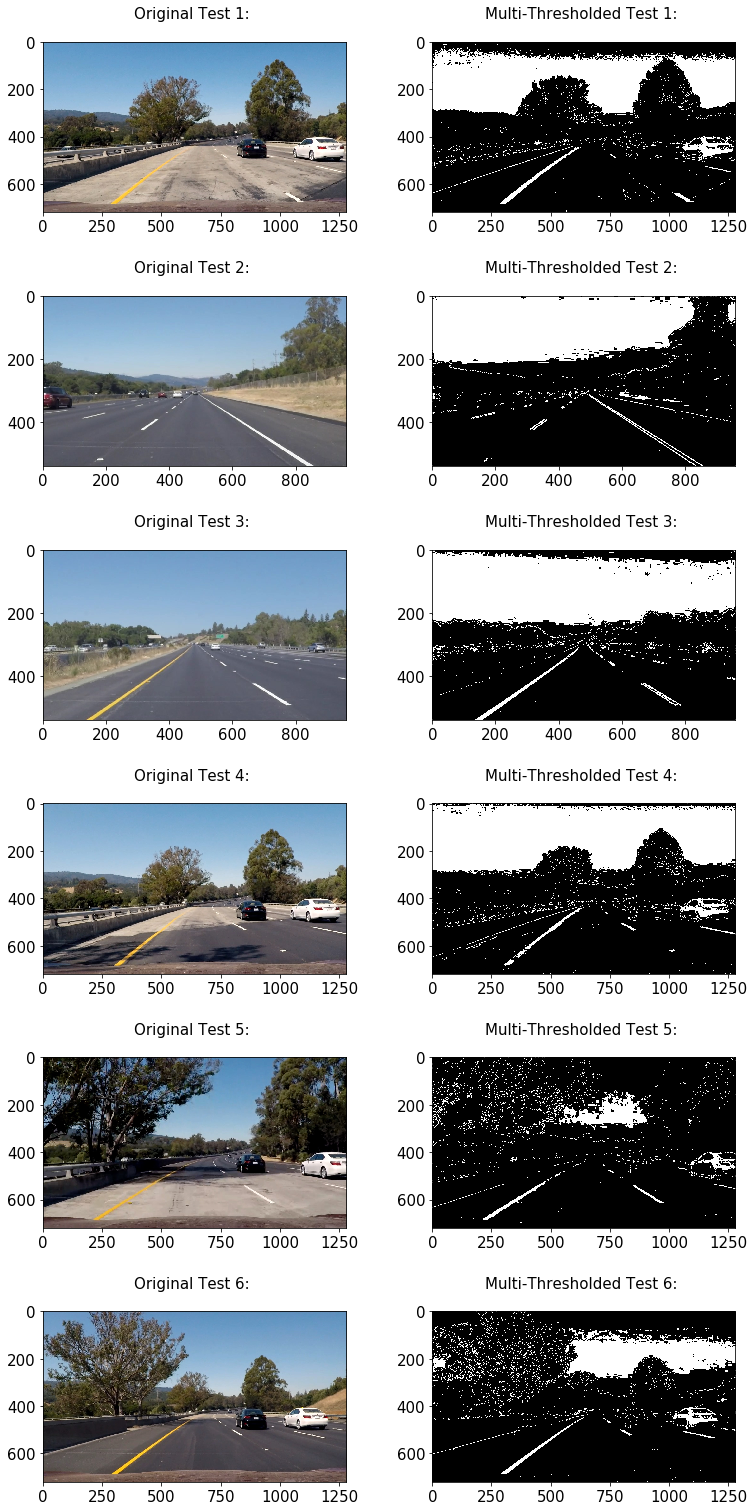

In [19]:
def process_image(img):
    color = color_threshold(img, HLS_s_threshold=(100, 255), HSV_v_threshold=(200,255))
    binary_x = sobel_operator(img, orient='x', threshold_MIN=15, threshold_MAX=255)
    binary_y = sobel_operator(img, orient='y', threshold_MIN=35, threshold_MAX=255)
    mag = gradient_magnitude(img, sobel_kernel=5, mag_threshold=(60, 255))
    direct = gradient_direction(img, sobel_kernel=9, thresh=(0.8, 1.1))
    output = combined_thresholds(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
                                binary_x,
                                binary_y,
                                mag,
                                direct,
                                color)
    return output

f, ((ax1, ax2), 
    (ax3, ax4), 
    (ax5, ax6),
    (ax7, ax8),
    (ax9, ax10),
    (ax11, ax12)) = plt.subplots(6, 2, figsize=(10, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

img = cv2.imread('resources/test_images/test1.jpg')
new_img1 = process_image(img)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Test 1: \n', fontsize=15)
ax2.imshow(new_img1, cmap='gray')
ax2.set_title('Multi-Thresholded Test 1: \n', fontsize=15)

img = cv2.imread('resources/test_images/test2.jpg')
new_img2 = process_image(img)
ax3.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax3.set_title('Original Test 2: \n', fontsize=15)
ax4.imshow(new_img2, cmap='gray')
ax4.set_title('Multi-Thresholded Test 2: \n', fontsize=15)

img = cv2.imread('resources/test_images/test3.jpg')
new_img3 = process_image(img)
ax5.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax5.set_title('Original Test 3: \n', fontsize=15)
ax6.imshow(new_img3, cmap='gray')
ax6.set_title('Multi-Thresholded Test 3: \n', fontsize=15)

img = cv2.imread('resources/test_images/test4.jpg')
new_img4 = process_image(img)
ax7.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax7.set_title('Original Test 4: \n', fontsize=15)
ax8.imshow(new_img4, cmap='gray')
ax8.set_title('Multi-Thresholded Test 4: \n', fontsize=15)

img = cv2.imread('resources/test_images/test5.jpg')
new_img5 = process_image(img)
ax9.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax9.set_title('Original Test 5: \n', fontsize=15)
ax10.imshow(new_img5, cmap='gray')
ax10.set_title('Multi-Thresholded Test 5: \n', fontsize=15)

img = cv2.imread('resources/test_images/test6.jpg')
new_img6 = process_image(img)
ax11.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax11.set_title('Original Test 6: \n', fontsize=15)
ax12.imshow(new_img6, cmap='gray')
ax12.set_title('Multi-Thresholded Test 6: \n', fontsize=15)

plt.subplots_adjust(left=0., right=1, top=2., bottom=0.)

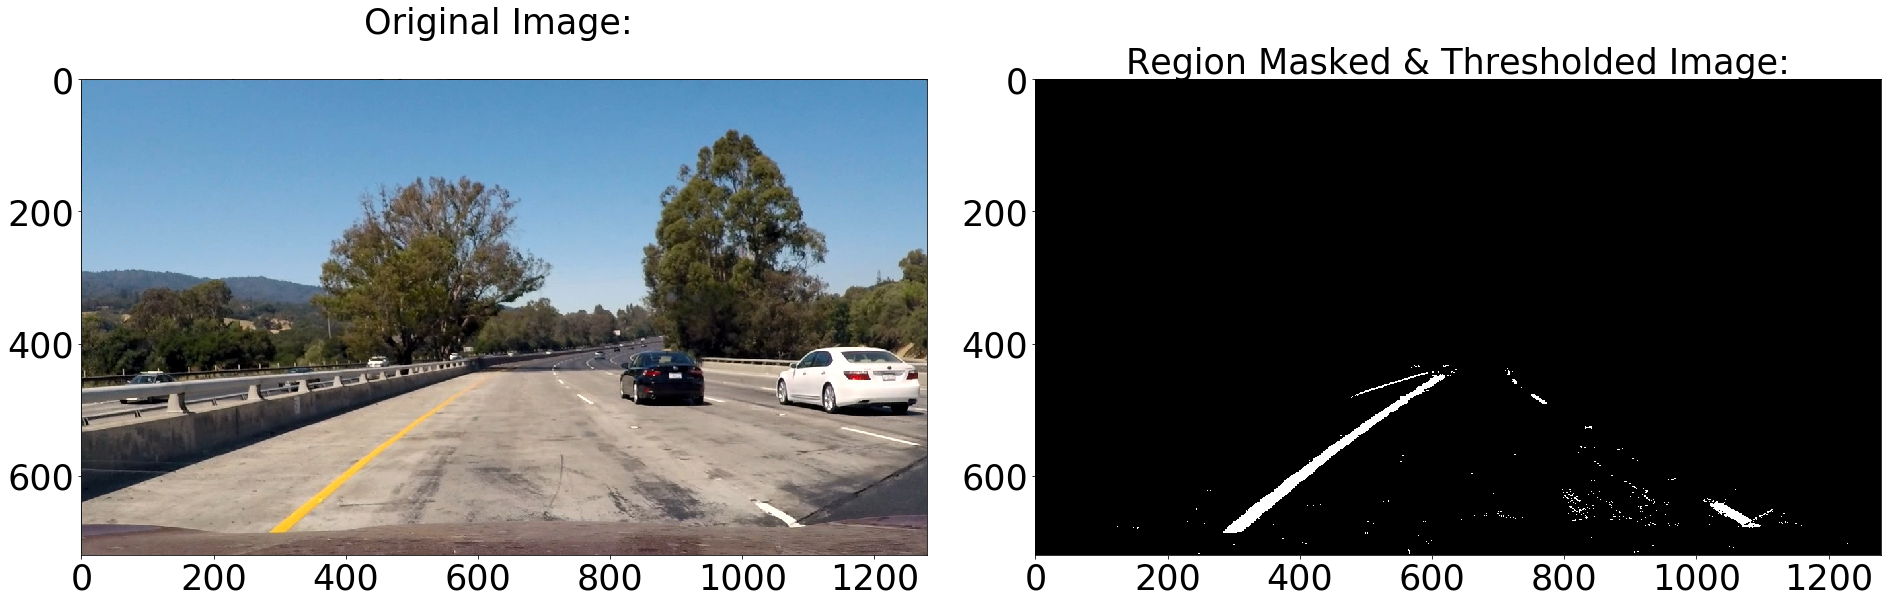

In [25]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

img = cv2.imread('resources/test_images/test1.jpg')
width = img.shape[1]
height = img.shape[0]
vertices = np.array([[(width*0.45, height*0.6),
                      (width*0.55, height*0.6),
                      (width, height),
                      (0, height)]], 
                    dtype=np.int32)
region = region_of_interest(new_img1, vertices)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(region, cmap='gray')
ax2.set_title('Region Masked & Thresholded Image:', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

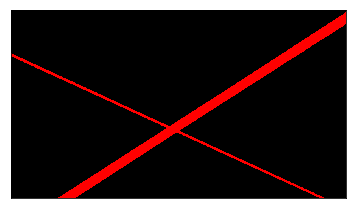

In [56]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            point = np.mean(line, axis=0)
            y = point[1]
            x = point[0] 
            intercept = y - slope*x
            yLeft = intercept
            yRight = slope * img.shape[1] + intercept
            cv2.line(line_img,
                     (0, int(yLeft)),
                     (img.shape[1], int(yRight)),
                     color=[255, 0, 0],
                     thickness=5)
                
    #Return image with Hough lines drawn
    return line_img

rho = 2
theta = 60/180
threshold = 40
min_line_length = 70
max_line_gap = 2

hough = hough_lines(region, rho, theta, threshold, min_line_length, max_line_gap)
region2 = region_of_interest(hough, vertices)
plt.imshow(hough);
plt.xticks(()); plt.yticks(());

### IV. Perspective Transform
#### Apply a perspective transform to rectify binary image ("birds-eye view").

In [ ]:
def perspective_transform(img, src):
    
    # Construct the destination points to obtain bird's-eye view
    dst = np.array([[0,0], 
                    [img.shape[1], 0], 
                    [img.shape[1], img.shape[0]],
                    [0, img.shape[0]]],
                    dtype = 'float32')
    
    # Compute the perspective transform, M, given source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp an image using the perspective transform, M
    warped_output = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    
    # Return the resulting image
    return warped_output


In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(region)
ax2.set_title('Perspective Transform: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(cv2.cvtColor(perspective, cv2.COLOR_BGR2RGB))
ax2.set_title('Perspective Transform: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

### V. Detecting Lane Lines
#### Detect lane pixels and fit to find the lane boundary.

In [ ]:
#I first take a histogram along all the columns in the lower half of the image like this:

#img = INSERT_thresholded and warped image here!
histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [ ]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            point = np.mean(line, axis=0)
            y = point[1]
            x = point[0]
            if slope < 0: 
                intercept = y - slope*x
                yLeft = intercept
                yRight = slope * 960 + intercept
                cv2.line(img, (0, int(yLeft)), (960, int(yRight)), color, thickness)
            if slope > 0:
                intercept = y - slope*x
                yLeft = intercept
                yRight = slope * 960 + intercept
                cv2.line(img, (0, int(yLeft)), (960, int(yRight)), color, thickness)

rho = 2
theta = 1/180
threshold = 50
min_line_length = 10
max_line_gap = 20
v
                
draw_lines(img, )

### VI. Determining Lane Curvature & Warping to Original Image

#### Determine the curvature of the lane and vehicle position with respect to center.

#### Warp the detected lane boundaries back onto the original image.

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(yvals)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1163.9    1213.7

http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

left_fit_cr = np.polyfit(yvals*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(yvals*ym_per_pix, rightx*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 3380.7 m    3189.3 m

### VII. Output
#### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Classes & Helper Methods

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### Lane Detection